In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from open3d.ml.torch.layers import SparseConv, SparseConvTranspose

In [7]:
%matplotlib inline

In [8]:
data = np.load('/mnt/c/Users/user/Desktop/data.npy')

In [9]:
N = data.shape[0]
print(f'We have {N} samples')

We have 111620 samples


In [10]:
# converting our numpy arrays to pytorch tensors
train_data = torch.from_numpy(data[:, :-1])
labels = data[:, -1]
labels = torch.from_numpy(labels).type(torch.LongTensor)

In [11]:
unique_labels = np.unique(labels)
print('Number of unique labels:', unique_labels.shape[0])
print('Unique labels are:', *unique_labels)

Number of unique labels: 12
Unique labels are: 0 1 2 4 5 6 7 8 9 10 11 12


As we observe there is no sample for class 3

In [12]:
# this is a custom class to create a dataset from our tensors to put them in data loader for batch learning
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [13]:
dataset = MyDataset(train_data, labels)
data_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [14]:
# due to computation small number of filters have been used
class SemSeg(nn.Module):
    def __init__(self, in_ch, filters_list=[16, 32, 64], kernel_size=[3, 3, 3]):
        super().__init__()
        self.conv1 = SparseConv(in_channels=in_ch, filters=filters_list[0], kernel_size=kernel_size)
        self.conv2 = SparseConv(in_channels=filters_list[0], filters=filters_list[1], kernel_size=kernel_size)
        self.conv3 = SparseConv(in_channels=filters_list[1], filters=filters_list[2], kernel_size=kernel_size)
        
        self.deconv1 = SparseConvTranspose(in_channels=filters_list[2], filters=filters_list[2], kernel_size=kernel_size)
        self.deconv2 = SparseConvTranspose(in_channels=filters_list[2], filters=filters_list[1], kernel_size=kernel_size)
        self.deconv3 = SparseConvTranspose(in_channels=filters_list[1], filters=13, kernel_size=kernel_size)
        
    def forward(self, in_feat, in_pos, out_pos, voxel_size=0.02):
        out_feat = F.relu(self.conv1(in_feat, in_pos, out_pos, voxel_size))
        out_feat = F.relu(self.conv2(out_feat, in_pos, out_pos, voxel_size*2))
        out_feat = F.relu(self.conv3(out_feat, in_pos, out_pos, voxel_size*4))
        
        out_feat = F.relu(self.deconv1(out_feat, in_pos, out_pos, voxel_size*4))
        out_feat = F.relu(self.deconv2(out_feat, in_pos, out_pos, voxel_size*2))
        out_feat = self.deconv3(out_feat, in_pos, out_pos, voxel_size)
        return out_feat

In [15]:
model =  SemSeg(3)
model

SemSeg(
  (conv1): SparseConv(
    (fixed_radius_search): FixedRadiusSearch()
  )
  (conv2): SparseConv(
    (fixed_radius_search): FixedRadiusSearch()
  )
  (conv3): SparseConv(
    (fixed_radius_search): FixedRadiusSearch()
  )
  (deconv1): SparseConvTranspose(
    (fixed_radius_search): FixedRadiusSearch()
  )
  (deconv2): SparseConvTranspose(
    (fixed_radius_search): FixedRadiusSearch()
  )
  (deconv3): SparseConvTranspose(
    (fixed_radius_search): FixedRadiusSearch()
  )
)

In [16]:
# we use Cross Entropy Loss as our error function and Adam optimizer to update the weights
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [17]:
train_loss = []
train_acc = []
epochs = 10

for epoch in range(epochs):
    train_corr = 0
    for batch_idx, (X_train, y_train) in enumerate(data_loader):
        batch_idx += 1
        
        # first 3 columns - x, y, z coordinates; last 3 columns - R, G, B features
        in_pos = X_train[:, :3]
        in_feat = X_train[:, 3:]
        
        # calculating the loss and adding number representing predicted correct classes for the current batch 
        y_pred = model(in_feat, in_pos, in_pos)
        loss = criterion(y_pred, y_train)
        
        y_pred = torch.max(y_pred.data, 1)[1]
        train_corr += (y_pred == y_train).sum().item()
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # analyzing the loss and training accuracy after each 400 batch
        if batch_idx % 400 == 0:
            print(f"Epoch {epoch} batch {batch_idx} loss: {loss.item():.3f} accuracy: {((train_corr / (batch_idx * 32)) * 100):.3f} %")
    
    # lastly we add our final loss and training accuracy to furhter analyzing of changes over epoches
    train_loss.append(loss.item())
    train_acc.append(train_corr / N)

Epoch 0 batch 400 loss: 2.208 accuracy: 20.594 %
Epoch 0 batch 800 loss: 1.960 accuracy: 24.527 %
Epoch 0 batch 1200 loss: 2.129 accuracy: 27.336 %
Epoch 0 batch 1600 loss: 1.540 accuracy: 30.098 %
Epoch 0 batch 2000 loss: 1.697 accuracy: 31.989 %
Epoch 0 batch 2400 loss: 1.921 accuracy: 33.678 %
Epoch 0 batch 2800 loss: 1.728 accuracy: 34.792 %
Epoch 0 batch 3200 loss: 1.601 accuracy: 35.950 %
Epoch 1 batch 400 loss: 1.390 accuracy: 43.727 %
Epoch 1 batch 800 loss: 1.601 accuracy: 43.887 %
Epoch 1 batch 1200 loss: 1.482 accuracy: 44.245 %
Epoch 1 batch 1600 loss: 1.555 accuracy: 44.250 %
Epoch 1 batch 2000 loss: 1.722 accuracy: 44.386 %
Epoch 1 batch 2400 loss: 1.532 accuracy: 44.617 %
Epoch 1 batch 2800 loss: 1.548 accuracy: 44.781 %
Epoch 1 batch 3200 loss: 1.333 accuracy: 44.891 %
Epoch 2 batch 400 loss: 1.511 accuracy: 46.406 %
Epoch 2 batch 800 loss: 1.694 accuracy: 46.289 %
Epoch 2 batch 1200 loss: 1.207 accuracy: 46.242 %
Epoch 2 batch 1600 loss: 1.511 accuracy: 46.396 %
Epoch 

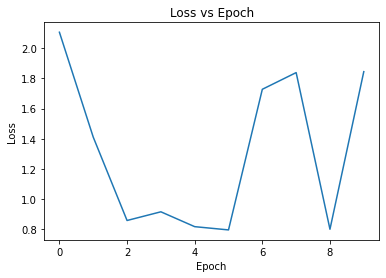

In [22]:
# visualizing the losses over epochs
fig1, ax1 = plt.subplots()
fig1.patch.set_facecolor('white')
ax1.set_title("Loss vs Epoch")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(train_loss, label = "train loss")
fig1.savefig('loss.png', dpi=300)
plt.show();

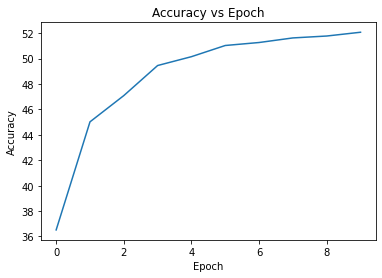

In [24]:
# visualizing th training accuracy over epochs
fig2, ax2 = plt.subplots()
fig2.patch.set_facecolor('white')
ax2.set_title("Accuracy vs Epoch")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot([acc * 100 for acc in train_acc], label = "train accuracy")
fig2.savefig('accuracy.png', dpi=300)
plt.show()

In [20]:
# predicting final results on whole data
in_pos = train_data[:, :3]
in_features = train_data[:, 3:]
y_pred = model(in_features, in_pos, in_pos)
y_pred = torch.max(y_pred, 1)[1]

In [21]:
print(f'Final Accuracy is {((y_pred == labels).sum().item() * 100 / N):.3f}%')

Final Accuracy is 22.045%
